# Multi-Class Image Classification Model for Rice Images Identification Using TensorFlow Take 2
### David Lowe
### March 15, 2022

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: This project aims to construct a predictive model using a TensorFlow convolutional neural network (CNN) and document the end-to-end steps using a template. The Rice Images Identification dataset is a multi-class classification situation where we attempt to predict one of several (more than two) possible outcomes.

INTRODUCTION: The dataset owner collected 75,000 pieces of rice grain and created a dataset that classifies the grains into one of the varieties (Arborio, Basmati, Ipsala, Jasmine, Karacadag). The research team applied various preprocessing operations to the rice images and obtained the features. The image size in which each grain of rice is 250 × 250 pixels.

ANALYSIS: The DenseNet201 model's performance achieved an accuracy score of 83.12% after ten epochs using a validation dataset with 20% of total images. After tuning the learning rate, we improved the accuracy rate to 96.47% using the same validation dataset.

CONCLUSION: In this iteration, the TensorFlow DenseNet201 CNN model appeared suitable for modeling this dataset.

Dataset Used: Rice Image Dataset

Dataset ML Model: Multi-Class classification with numerical features

Dataset Reference: https://www.kaggle.com/mkoklu42/rice-image-dataset

One source of potential performance benchmarks: https://www.kaggle.com/mkoklu42/rice-image-dataset/code

# Task 1 - Prepare Environment

In [1]:
# # Install the packages to support accessing environment variable and SQL databases
# !pip install python-dotenv PyMySQL boto3

In [2]:
# Retrieve CPU information from the system
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 12


In [3]:
# Retrieve memory configuration information
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Your runtime has 89.6 gigabytes of available RAM



In [4]:
# Retrieve GPU configuration information
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

Mon Mar  7 21:23:06 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    43W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
# # Mount Google Drive locally for loading the dotenv files
# from dotenv import load_dotenv
# from google.colab import drive
# drive.mount('/content/gdrive')
# gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
# env_path = '/content/gdrive/My Drive/Colab Notebooks/'
# dotenv_path = env_path + "python_script.env"
# load_dotenv(dotenv_path=dotenv_path)

## 1.a) Load libraries and modules

In [6]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [7]:
import random
random.seed(RNG_SEED)
import numpy as np
np.random.seed(RNG_SEED)
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sys
import math
# import boto3
import zipfile
from datetime import datetime
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import tensorflow as tf
tf.random.set_seed(RNG_SEED)
from tensorflow import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## 1.b) Set up the controlling parameters and functions

In [8]:
# Begin the timer for the script processing
START_TIME_SCRIPT = datetime.now()

In [9]:
# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
TEST_SET_RATIO = 0.2
VAL_SET_RATIO = 0.2

# Set the number of folds for cross validation
N_FOLDS = 5
N_ITERATIONS = 1

# Set various default modeling parameters
DEFAULT_LOSS = 'categorical_crossentropy'
DEFAULT_METRICS = ['accuracy']
DEFAULT_OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.01)
CLASSIFIER_ACTIVATION = 'softmax'
MAX_EPOCHS = 10
BATCH_SIZE = 32
NUM_CLASSES = 5
# CLASS_LABELS = []
# CLASS_NAMES = []
# RAW_IMAGE_SIZE = (250, 250)
TARGET_IMAGE_SIZE = (224, 224)
INPUT_IMAGE_SHAPE = (TARGET_IMAGE_SIZE[0], TARGET_IMAGE_SIZE[1], 3)

# Define the labels to use for graphing the data
TRAIN_METRIC = "accuracy"
VALIDATION_METRIC = "val_accuracy"
TRAIN_LOSS = "loss"
VALIDATION_LOSS = "val_loss"

# Define the directory locations and file names
STAGING_DIR = 'staging/'
TRAIN_DIR = 'staging/Rice_Image_Dataset/'
VALID_DIR = ''
TEST_DIR = ''
TRAIN_DATASET = 'Rice_Image_Dataset.zip'
# VALID_DATASET = ''
# TEST_DATASET = ''
# TRAIN_LABELS = ''
# VALID_LABELS = ''
# TEST_LABELS = ''
# OUTPUT_DIR = 'staging/'
# SAMPLE_SUBMISSION_CSV = 'sample_submission.csv'
# FINAL_SUBMISSION_CSV = 'submission.csv'

# Check the number of GPUs accessible through TensorFlow
print('Num GPUs Available:', len(tf.config.list_physical_devices('GPU')))

# Print out the TensorFlow version for confirmation
print('TensorFlow version:', tf.__version__)

Num GPUs Available: 1
TensorFlow version: 2.8.0


In [10]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [11]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 1 - Prepare Environment has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [12]:
# Reset the random number generators
def reset_random(x=RNG_SEED):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [13]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 1 - Prepare Environment completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 2 - Load and Prepare Images

In [14]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 2 - Load and Prepare Images has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [15]:
# Clean up the old files and download directories before receiving new ones
!rm -rf staging/
# !rm Rice_Image_Dataset.zip
!mkdir staging/

In [16]:
if not os.path.exists(TRAIN_DATASET):
    !wget https://dainesanalytics.com/datasets/kaggle-mkoklu42-rice-msc-dataset/Rice_Image_Dataset.zip

--2022-03-07 21:23:10--  https://dainesanalytics.com/datasets/kaggle-mkoklu42-rice-msc-dataset/Rice_Image_Dataset.zip
Resolving dainesanalytics.com (dainesanalytics.com)... 13.226.50.69, 13.226.50.115, 13.226.50.123, ...
Connecting to dainesanalytics.com (dainesanalytics.com)|13.226.50.69|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 229550002 (219M) [application/zip]
Saving to: ‘Rice_Image_Dataset.zip’

Rice_Image_Dataset. 100%[===================>] 218.92M  96.3MB/s    in 2.3s    

2022-03-07 21:23:13 (96.3 MB/s) - ‘Rice_Image_Dataset.zip’ saved [229550002/229550002]



In [17]:
zip_ref = zipfile.ZipFile(TRAIN_DATASET, 'r')
zip_ref.extractall(STAGING_DIR)
zip_ref.close()

In [18]:
citation_request_file = TRAIN_DIR + 'Rice_Citation_Request.txt'
if os.path.exists(citation_request_file):
    !rm staging/Rice_Image_Dataset/Rice_Citation_Request.txt

In [19]:
CLASS_LABELS = os.listdir(TRAIN_DIR)
print(CLASS_LABELS)

['Basmati', 'Karacadag', 'Jasmine', 'Arborio', 'Ipsala']


In [20]:
# Brief listing of training image files for each class
for c_label in CLASS_LABELS:
    training_class_dir = os.path.join(TRAIN_DIR, c_label)
    training_class_files = os.listdir(training_class_dir)
    print('Number of training images for', c_label, ':', len(os.listdir(training_class_dir)))
    print('Training samples for', c_label, ':', training_class_files[:5],'\n')

Number of training images for Basmati : 15000
Training samples for Basmati : ['basmati (6166).jpg', 'basmati (14161).jpg', 'basmati (13851).jpg', 'basmati (3954).jpg', 'basmati (13078).jpg'] 

Number of training images for Karacadag : 15000
Training samples for Karacadag : ['Karacadag (11946).jpg', 'Karacadag (14351).jpg', 'Karacadag (6722).jpg', 'Karacadag (8083).jpg', 'Karacadag (338).jpg'] 

Number of training images for Jasmine : 15000
Training samples for Jasmine : ['Jasmine (10754).jpg', 'Jasmine (8136).jpg', 'Jasmine (5696).jpg', 'Jasmine (8347).jpg', 'Jasmine (6434).jpg'] 

Number of training images for Arborio : 15000
Training samples for Arborio : ['Arborio (1223).jpg', 'Arborio (5752).jpg', 'Arborio (13477).jpg', 'Arborio (9621).jpg', 'Arborio (11427).jpg'] 

Number of training images for Ipsala : 15000
Training samples for Ipsala : ['Ipsala (1070).jpg', 'Ipsala (1355).jpg', 'Ipsala (10605).jpg', 'Ipsala (6543).jpg', 'Ipsala (8332).jpg'] 



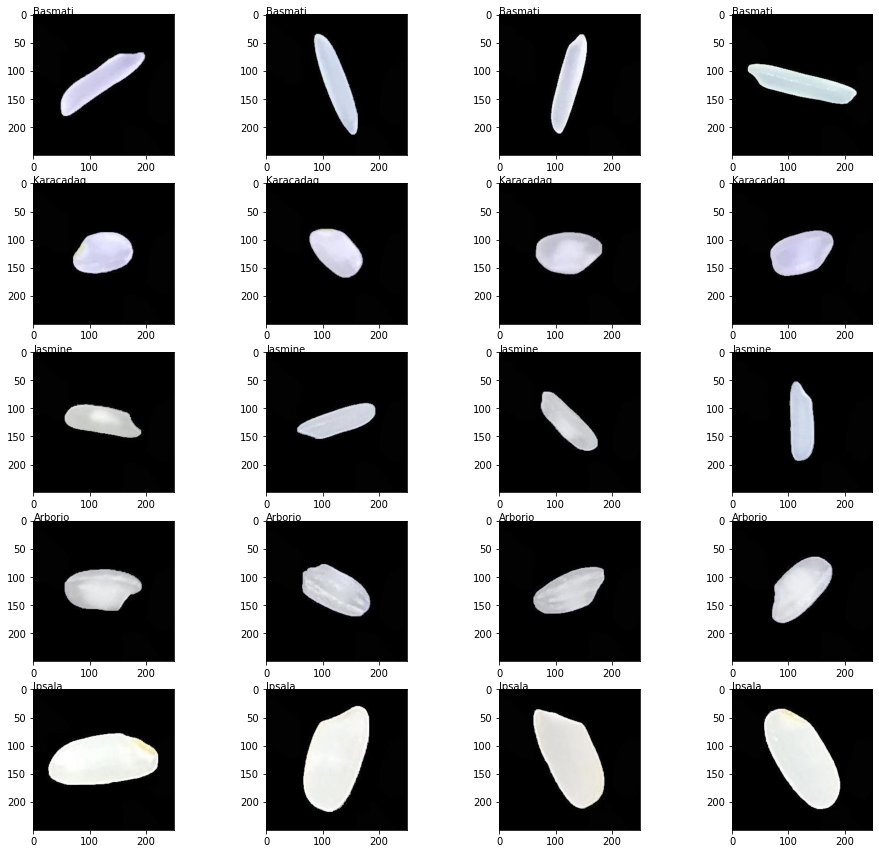

In [21]:
# Plot some training images from the dataset
nrows = len(CLASS_LABELS)
ncols = 4
training_examples = []
example_labels = []

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 3)

for c_label in CLASS_LABELS:
    training_class_dir = os.path.join(TRAIN_DIR, c_label)
    training_class_files = os.listdir(training_class_dir)
    for j in range(ncols):
        training_examples.append(training_class_dir + '/' + training_class_files[j])
        example_labels.append(c_label)
    # print(training_examples)
    # print(example_labels)

for i, img_path in enumerate(training_examples):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i+1)
    sp.text(0, 0, example_labels[i])
    # sp.axis('Off')
    img = mpimg.imread(img_path)
    plt.imshow(img)
plt.show()

In [22]:
datagen_kwargs = dict(rescale=1./255, validation_split=VAL_SET_RATIO)
training_datagen = ImageDataGenerator(**datagen_kwargs)
validation_datagen = ImageDataGenerator(**datagen_kwargs)
dataflow_kwargs = dict(class_mode="categorical")

do_data_augmentation = True
if do_data_augmentation:
    training_datagen = ImageDataGenerator(rotation_range=45,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          **datagen_kwargs)

print('Loading and pre-processing the training images...')
training_generator = training_datagen.flow_from_directory(directory=TRAIN_DIR,
                                                          target_size=TARGET_IMAGE_SIZE,
                                                          batch_size=BATCH_SIZE,
                                                          shuffle=True,
                                                          seed=RNG_SEED,
                                                          subset="training",
                                                          **dataflow_kwargs)
print('Number of training image batches per epoch of modeling:', len(training_generator))

print('Loading and pre-processing the validation images...')
validation_generator = validation_datagen.flow_from_directory(directory=TRAIN_DIR,
                                                              target_size=TARGET_IMAGE_SIZE,
                                                              batch_size=BATCH_SIZE,
                                                              shuffle=False,
                                                              subset="validation",
                                                              **dataflow_kwargs)
print('Number of validation image batches per epoch of modeling:', len(validation_generator))

Loading and pre-processing the training images...
Found 60000 images belonging to 5 classes.
Number of training image batches per epoch of modeling: 1875
Loading and pre-processing the validation images...
Found 15000 images belonging to 5 classes.
Number of validation image batches per epoch of modeling: 469


In [23]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 2 - Load and Prepare Images completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 3 - Define and Train Models

In [24]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 3 - Define and Train Models has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [25]:
# Define the function for plotting training results for comparison
def plot_metrics(history):
    fig, axs = plt.subplots(1, 2, figsize=(24, 15))
    metrics =  [TRAIN_LOSS, TRAIN_METRIC]
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color='blue', label='Train')
        plt.plot(history.epoch, history.history['val_'+metric], color='red', linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == TRAIN_LOSS:
            plt.ylim([0, plt.ylim()[1]])
        else:
            plt.ylim([0, 1])
        plt.legend()

In [26]:
# Define the baseline model for benchmarking
def create_nn_model(input_param=INPUT_IMAGE_SHAPE, output_param=NUM_CLASSES, dense_nodes=2048,
                    classifier_activation=CLASSIFIER_ACTIVATION, loss_param=DEFAULT_LOSS,
                    opt_param=DEFAULT_OPTIMIZER, metrics_param=DEFAULT_METRICS):
    base_model = keras.applications.densenet.DenseNet201(include_top=False, weights='imagenet', input_shape=input_param)
    nn_model = keras.models.Sequential()
    nn_model.add(base_model)
    nn_model.add(keras.layers.Flatten())
    nn_model.add(keras.layers.Dense(dense_nodes, activation='relu')),
    nn_model.add(keras.layers.Dense(output_param, activation=classifier_activation))
    nn_model.compile(loss=loss_param, optimizer=opt_param, metrics=metrics_param)
    return nn_model

In [27]:
# Initialize the neural network model and get the training results for plotting graph
start_time_module = datetime.now()
tf.keras.backend.clear_session()
reset_random()
baseline_model = create_nn_model()
baseline_model_history = baseline_model.fit(training_generator,
                                            epochs=MAX_EPOCHS,
                                            validation_data=validation_generator,
                                            verbose=1)
print('Total time for model fitting:', (datetime.now() - start_time_module))

74850304/74836368 [==============================] - 1s 0us/step
Epoch 1/10
1875/1875 [==============================] - 696s 355ms/step - loss: 5.0204 - accuracy: 0.8619 - val_loss: 3.0017 - val_accuracy: 0.3032
Epoch 2/10
1875/1875 [==============================] - 660s 352ms/step - loss: 1.2442 - accuracy: 0.8056 - val_loss: 0.5976 - val_accuracy: 0.7595
Epoch 3/10
1875/1875 [==============================] - 659s 351ms/step - loss: 0.2254 - accuracy: 0.9292 - val_loss: 8.5996 - val_accuracy: 0.6097
Epoch 4/10
1875/1875 [==============================] - 658s 351ms/step - loss: 0.1277 - accuracy: 0.9658 - val_loss: 0.2306 - val_accuracy: 0.9422
Epoch 5/10
1875/1875 [==============================] - 659s 351ms/step - loss: 0.1223 - accuracy: 0.9676 - val_loss: 0.0911 - val_accuracy: 0.9667
Epoch 6/10
1875/1875 [==============================] - 658s 351ms/step - loss: 1.2508 - accuracy: 0.9619 - val_loss: 0.0792 - val_accuracy: 0.9679
Epoch 7/10
1875/1875 [=========================

In [28]:
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 flatten (Flatten)           (None, 94080)             0         
                                                                 
 dense (Dense)               (None, 2048)              192677888 
                                                                 
 dense_1 (Dense)             (None, 5)                 10245     
                                                                 
Total params: 211,010,117
Trainable params: 210,781,061
Non-trainable params: 229,056
_________________________________________________________________


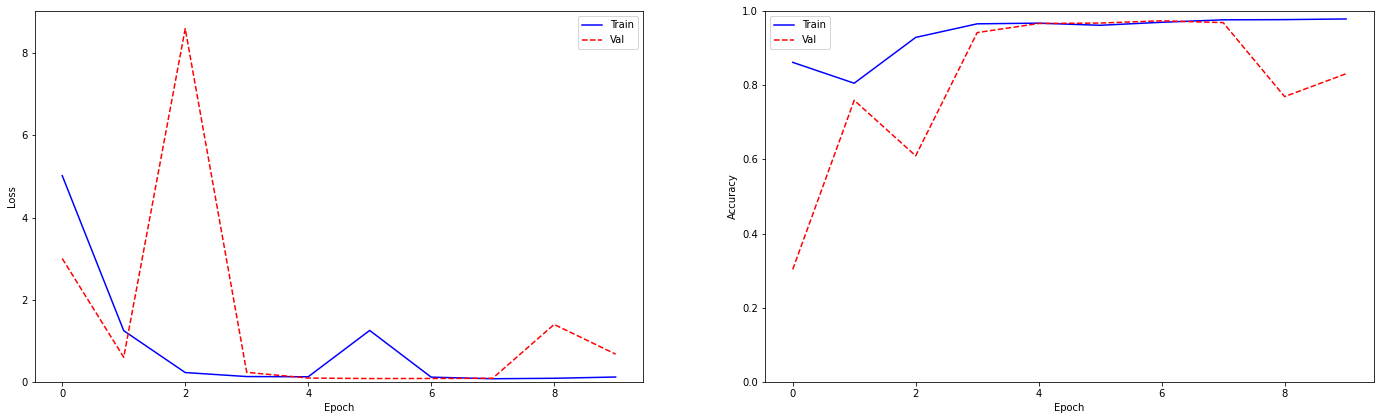

In [29]:
plot_metrics(baseline_model_history)

In [30]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 3 - Define and Train Models completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 4 - Tune and Optimize Models

In [31]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 4 - Tune and Optimize Models has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [32]:
# Initialize the neural network model and get the training results for plotting graph
start_time_module = datetime.now()
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.000125)
TUNE_OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.001)
tf.keras.backend.clear_session()
reset_random()
tune_model = create_nn_model(opt_param=TUNE_OPTIMIZER)
tune_model_history = tune_model.fit(training_generator,
                                    epochs=MAX_EPOCHS,
                                    validation_data=validation_generator,
                                    callbacks=[learning_rate_reduction],
                                    verbose=1)
print('Total time for model fitting:', (datetime.now() - start_time_module))

Epoch 1/10
1875/1875 [==============================] - 679s 353ms/step - loss: 0.5191 - accuracy: 0.9605 - val_loss: 0.4438 - val_accuracy: 0.8801 - lr: 0.0010
Epoch 2/10
1875/1875 [==============================] - 662s 353ms/step - loss: 0.1937 - accuracy: 0.9690 - val_loss: 0.5067 - val_accuracy: 0.8620 - lr: 0.0010
Epoch 3/10
1875/1875 [==============================] - 660s 352ms/step - loss: 0.0653 - accuracy: 0.9844 - val_loss: 0.1180 - val_accuracy: 0.9625 - lr: 0.0010
Epoch 4/10
1875/1875 [==============================] - 658s 351ms/step - loss: 0.0393 - accuracy: 0.9878 - val_loss: 0.8193 - val_accuracy: 0.7781 - lr: 0.0010
Epoch 5/10
1875/1875 [==============================] - 660s 352ms/step - loss: 0.0396 - accuracy: 0.9884 - val_loss: 0.6587 - val_accuracy: 0.7965 - lr: 0.0010
Epoch 6/10
1875/1875 [==============================] - ETA: 0s - loss: 0.0372 - accuracy: 0.9882
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1875/1875 [==========

In [33]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 4 - Tune and Optimize Models completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 5 - Finalize Model and Make Predictions

In [34]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 5 - Finalize Model and Make Predictions has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

### 5.a) Train the Final Model

In [35]:
# Not applicable for this iteration of modeling

### 5.b) Load Test Dataset and Make Predictions

In [36]:
# Not applicable for this iteration of modeling

In [37]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 5 - Finalize Model and Make Predictions completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [38]:
print ('Total time for the script:',(datetime.now() - START_TIME_SCRIPT))

Total time for the script: 3:42:41.216834
